You can check and explore further methods applied the tasks we have previously covered from the following link:
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d313030

Skeleton code is provided from the following tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Dataset: https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR100

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import math
from timeit import default_timer as timer

print("Versions..........")
print("torch:       ", torch.__version__)
print("torchvision: ", torchvision.__version__)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


Versions..........
torch:        1.10.1+cu102
torchvision:  0.11.2+cu102


### Defining and testing custom image transformation

Files already downloaded and verified


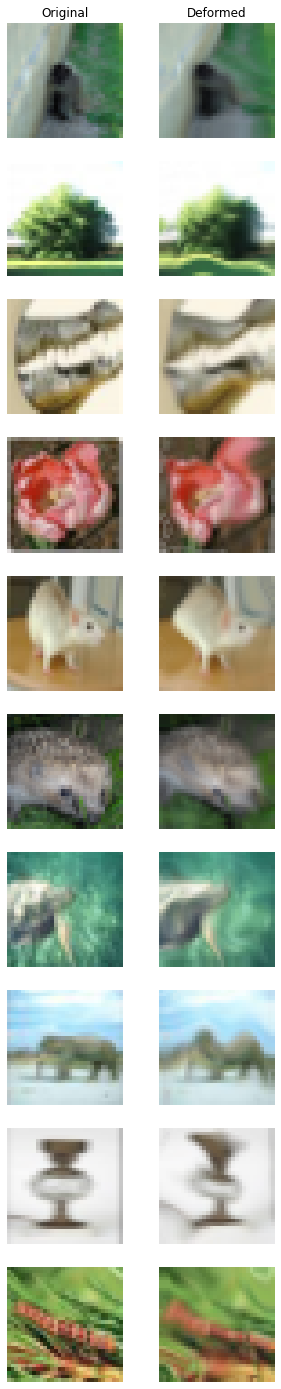

In [3]:
# [DONE] TODO: write at least one data transform or augmentation method yourself ==> DONE
class ElasticDeformation(object):
    """Elastic deformation used as image augmentation for classification task, as per the follwoing paper.
    Simard, Steinkraus and Platt, "Best Practices for Convolutional Neural Networks applied to Visual Document Analysis",
    in Proc. of the International Conference on Document Analysis and Recognition, 2003.

    Note that calling this class's function will treat its image input according to its class.
    If the image is a numpy array, it will be treated like an OpenCV image (channels last; H,W,C)
    If the image is a torch.tensor, it will be treated accordingly (channels first; C,H,W)

    Args:

    :param alpha: Size of distortion (pixels). typical value is between 1.5 and 3 x image height
    :param sigma: Variance of the Gaussian distribution with whom the uniform random displacement fields will be convolved. Typical value is between 0.01 and 0.1 image height.
    :param alpha_affine: Size of the affine transformations. Typical value is between 0.01 and 0.1 image height.
    :param random_state: State of the RNG for reproducibility of random displacement fields. Default is None.
    :param probability: Chance of the transform happening (it is a random deformation). Default is 1.0, meaning the transformation will definitely happen.
    :param output: Type of output for its callable function. Options are 'array' for OpenCV output (channels last), or 'tensor' for PyTorch Tensor (channels first)
    """
    def __init__(self, alpha, sigma, alpha_affine, random_state=None, probability=1.0, output='array'):
        self.alpha = alpha
        self.sigma = sigma
        self.alpha_affine = alpha_affine
        self.random_state = random_state
        self.probability = probability
        self.output = output


    def __call__(self, image):
        """Perform elastic transformation on an image using the class parameters for transformation.
    
        Args:
            :param image (numpy.ndarray or torch.tensor): Input image or tensor of image.
                Note that calling this class's function will treat its image input according to its class.
                If the image is a numpy array, it will be treated like an OpenCV image (channels last; H,W,C)
                If the image is a torch.tensor, it will be treated accordingly (channels first; C,H,W)

        Returns:
            :return image: If output=='array' in constructor, output will be an OpenCV array (channels last), if output=='tensor', a PyTorch tensor (channels first) will be returned.
        """
        if self.random_state is None:
            random_state = np.random.RandomState(None)

        if np.random.uniform() > self.probability:
            if 'tensor' in type(image).__name__.lower():
                if self.output=='tensor':
                    return image
                else:
                    return image.numpy().transpose((1,2,0))
            else:
                if self.output=='tensor':
                    return torch.tensor(image.transpose((2,0,1)))
                else:
                    return image
        
        image = image.numpy().transpose((1,2,0)) if 'tensor' in type(image).__name__.lower() else image
        
        shape = image.shape
        shape_size = shape[:2]
        
        # Random affine
        center_square = np.float32(shape_size) // 2
        square_size = min(shape_size) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-self.alpha_affine, self.alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), self.sigma) * self.alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), self.sigma) * self.alpha
        dz = np.zeros_like(dx)

        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

        out = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        return out if self.output=='array' else torch.tensor(out.transpose((2,0,1)))


    def __repr__(self):
        return self.__class__.__name__+"(\n"+\
            "    alpha = {},\n".format(self.alpha)+\
            "    sigma = {},\n".format(self.sigma)+\
            "    alpha_affine = {},\n".format(self.alpha_affine)+\
            "    random_state = {},\n".format(self.random_state)+\
            "    probability = {},\n".format(self.probability)+\
            "    output = {})".format(self.output)


def elastic_transform_batch(batch, alpha, sigma, alpha_affine, random_state=None, probability=1.0):
    # Perform Elastic Deformation on a whole batch. Here, batch can also be a torch tensor from a dataloader or something.
    distorter = ElasticDeformation(alpha, sigma, alpha_affine, random_state, probability, output='array')
    return np.concatenate([distorter(img) for img in batch]).reshape(batch.shape)


# Testing the elastic distorter
sampleset = torchvision.datasets.CIFAR100(root='./data/sample', train=False, download=True)
sampledata = sampleset.data[np.random.choice(len(sampleset),10),...]
h,w = sampledata.shape[1:3]
sampledata_deformed = elastic_transform_batch(sampledata, w*1.1, w*0.1, w*0.02)
plt.figure(figsize = (5,25))
i = 0
for idx in range(10):
    i += 1
    plt.subplot(10,2,i)
    plt.imshow(sampledata[idx,...])
    plt.axis('off')
    if i == 1: plt.title('Original')
    i += 1
    plt.subplot(10,2,i)
    plt.imshow(sampledata_deformed[idx,...])
    if i == 2: plt.title('Deformed')
    plt.axis('off')
plt.show()

### Preliminaries and Data Loaders

In [5]:
# [DONE] TODO: You may consider appyling more transform such as data augmentation methods, etc.
# TODO: You may consider hyperparameter optimization: in this cell, we have batch_size!
# [DONE] TODO: use the previously defined data transform/augmentation method in the following transform.

# Global constants
ELASTIC_ALPHA = 32*1.1
ELASTIC_SIGMA = 32*0.1
ELASTIC_ALPHA_AFFINE = 32*0.02
ELASTIC_PROBABILITY = 0.5
P_VERT_FLIP = 0.5
P_HORZ_FLIP = 0.5
JITTER_BRIGHTNESS = 0.1
JITTER_SATURATION = 0.1
JITTER_CONTRAST = 0.2
AFFINE_ROTATION = 50
AFFINE_TRANSLATION = (0.1, 0.1)
AFFINE_SCALE = (0.5, 1.5)
AFFINE_SHEAR = 20
NORM_MEAN = (0.5, 0.5, 0.5)
NORM_STD = (0.5, 0.5, 0.5)
VALIDATION_DATA = 0.2

# Hyperparameters
hparams = {
    'input_image_size':[32, 32],
    'batch_size': 16,
    'epochs': 10,
    'lr': 0.001,
    'loss_function': nn.CrossEntropyLoss(),
    'optimizer':'adam',
    'optimizer_params':None,
    'num_conv_blocks': 3,
    'num_dense_layers':3,
    'conv_kernel_size':5,
    'pool_kernel_size':2,
    'conv_padding':0,
    'pool_padding':0,
    'conv_activations':nn.ReLU(),
    'dense_activations':nn.ReLU(),
    'conv_batchnorm':'before',
    'dense_batchnorm':'before',
    'conv_stride':1,
    'pool_stride':1,
    'dense_sizes':[256,128],
    'conv_dropout':0.2,
    'dense_dropout':0.2,
    'L2':0.001,
    'num_classes':100}


transform = transforms.Compose([
        transforms.ToTensor(),
        ElasticDeformation(ELASTIC_ALPHA, ELASTIC_SIGMA, ELASTIC_ALPHA_AFFINE, random_state=None, probability=ELASTIC_PROBABILITY, output='tensor'),
        transforms.RandomVerticalFlip(P_VERT_FLIP),
        transforms.RandomHorizontalFlip(P_HORZ_FLIP),
        transforms.ColorJitter(brightness=JITTER_BRIGHTNESS, contrast=JITTER_CONTRAST, saturation=JITTER_SATURATION),
        transforms.RandomAffine(AFFINE_ROTATION, AFFINE_TRANSLATION, AFFINE_SCALE, AFFINE_SHEAR),
        transforms.Normalize(NORM_MEAN, NORM_STD)])


allset = torchvision.datasets.CIFAR100(root='./data/CIFAR100', train=True, download=True, transform=transform)
num_all_data = len(allset.data)
num_val_data, num_train_data = int(VALIDATION_DATA*num_all_data), int((1-VALIDATION_DATA)*num_all_data)
(trainset, valset) = random_split(allset, (num_train_data, num_val_data), generator=torch.Generator().manual_seed(42))
trainloader = DataLoader(trainset, batch_size=hparams['batch_size'], shuffle=True, num_workers=0)
validloader = DataLoader(valset, batch_size=hparams['batch_size'], shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR100(root='./data/CIFAR100', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=hparams['batch_size'], shuffle=False, num_workers=0)

classes = ('apples', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottles', 
           'bowls', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'cans', 'castle', 'caterpillar', 'cattle', 'chair', 
           'chimpanzee', 'clock', 'cloud', 'cockroach', 'computer keyboard', 'couch', 'crab', 'crocodile', 
           'cups', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 
           'kangaroo', 'lamp', 'lawn-mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple', 'motorcycle', 
           'mountain', 'mouse', 'mushrooms', 'oak', 'oranges', 'orchids', 'otter', 'palm', 'pears', 'pickup truck', 
           'pine', 'plain', 'plates', 'poppies', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 
           'roses', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 
           'streetcar', 'sunflowers', 'sweet peppers', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
           'train', 'trout', 'tulips', 'turtle', 'wardrobe', 'whale', 'willow', 'wolf', 'woman', 'worm')

Files already downloaded and verified
Files already downloaded and verified


### Visualizing some normalized images

Shape of images:  torch.Size([16, 3, 32, 32])
Shape of labels:  torch.Size([16])
tensor([86, 68, 31, 99, 59, 69,  4, 18, 14, 19, 29,  3, 92, 50, 15, 64])


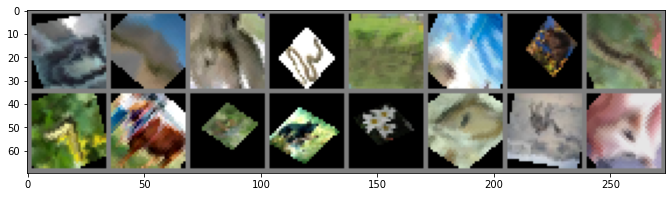

telephone,  road, dolphin,  worm,  pine, rocket, beaver, caterpillar, butterfly, cattle,  cups,  bear, tulips, mouse, camel, possum


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)

images, labels = dataiter.next()
#images, labels = testloader[0]
print("Shape of images: ", images.shape)
print("Shape of labels: ", labels.shape)
print(labels)
# show images
imshow(torchvision.utils.make_grid(images[:16]))
# print labels
print(', '.join('%5s' % classes[labels[j]] for j in range(hparams['batch_size'])))

### Constructing CNN model

In [7]:
# Base model, not to be used here
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 128)
        self.fc3 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
# [DONE] (Optional but highly recommended) TODO: You can define your own neural network to create a better performing model!
class ConvNet(nn.Module):
    def __init__(self, hparams:dict):
        super(ConvNet, self).__init__()
        self.hparams = hparams
        self.layers = []
        self._img_size = self.hparams['input_image_size']
        self._h, self._w = self._img_size
        self._img_size_list = [[3, self._h, self._w]]


        # Constructing the encoder (feature extractor)
        in_channels = 3
        out_channels = 16
        for i in range(self.hparams['num_conv_blocks']):
            self.layers.append(nn.Conv2d(in_channels, out_channels, self.hparams['conv_kernel_size'], padding=self.hparams['conv_padding'], stride=self.hparams['conv_stride']))
            self._update_image_size(out_channels, 'conv')
            if self.hparams['conv_batchnorm']=='before':
                self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(self.hparams['conv_activations'])
            if self.hparams['conv_batchnorm']=='after':
                self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.MaxPool2d(self.hparams['pool_kernel_size'], padding=self.hparams['pool_padding'], stride=self.hparams['pool_stride']))
            self._update_image_size(out_channels, 'pool')
            if self.hparams.get('conv_dropout'):
                self.layers.append(nn.Dropout2d(self.hparams['conv_dropout']))
            if i < self.hparams['num_conv_blocks'] - 1:
                in_channels = out_channels
                out_channels *= 2

        # Flattening (Image embedding)
        self.layers.append(nn.Flatten())

        # Constructing the decoder (classifier)
        if self.hparams.get('dense_sizes'):
            size_vec = self.hparams.get('dense_sizes')
        else:
            size_vec = [0] * self.hparams['num_fc_layers']
            size_vec[-1] = np.power(2, np.ceil(np.log2(self.hparams['num_classes']))).astype(int)
            for i in range(self.hparams['num_dense_layers']-2, -1, -1):
                size_vec[i] = size_vec[i+1] * 2
        in_size = out_channels*self._h*self._w
        out_size = size_vec[0]
        for i in range(len(size_vec)):
            self.layers.append(nn.Linear(in_size, out_size))
            if self.hparams['dense_batchnorm'] == 'before':
                self.layers.append(nn.BatchNorm1d(out_size))
            self.layers.append(self.hparams['dense_activations'])
            if self.hparams['dense_batchnorm'] == 'after':
                self.layers.append(nn.BatchNorm1d(out_size))
            if self.hparams.get('dense_dropout'):
                self.layers.append(nn.Dropout(self.hparams['dense_dropout']))
            if i < len(size_vec) - 1:
                in_size = out_size
                out_size = size_vec[i+1]
        self.layers.append(nn.Linear(out_size, self.hparams['num_classes']))

        # Constructing model
        self.net = nn.Sequential(*self.layers)

                
    def _calc_size(self, size_in:int, padding:int, kernel_size:int, stride:int):
        return math.floor((size_in + 2*padding - (kernel_size-1) - 1)/stride + 1)    
    
    def _update_image_size(self, out_channels, ops:str='conv'):
        (self._h, self._w) = (self._calc_size(sz, self.hparams[ops+'_padding'], self.hparams[ops+'_kernel_size'], self.hparams[ops+'_stride']) for sz in (self._h,self._w))
        self._img_size = (self._h, self._w)
        #print("new size: ",self._img_size)
        self._img_size_list.append([out_channels, self._h, self._w])

    def forward(self, x:torch.Tensor):
        return self.net(x)


# Instantiation
inzvaNet = ConvNet(hparams)
print("Built network is:")
print(inzvaNet)
print("Image sizes as they go through the convolution blocks:")
print(np.array(inzvaNet._img_size_list))

Built network is:
ConvNet(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.2, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=18496, ou

### Checking GPU availability

In [9]:
# if you want to train on GPU:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Instantiating CNN and defining training procedure

In [33]:
inzvaNet.to(device)
inzvaNet.train()

# base optimizer with following parameters:
criterion = hparams['loss_function']
if hparams['optimizer']=='adam':
    if hparams.get('optimizer_params'):
        optimizer = optim.Adam(inzvaNet.parameters(), lr=hparams['lr'], **hparams['optimizer_params'])
    else:
        optimizer = optim.Adam(inzvaNet.parameters(), lr=hparams['lr'])
elif hparams['optimizer']=='sgd':
    if hparams.get('optimizer_params'):
        optimizer = optim.SGD(inzvaNet.parameters(), lr=hparams['lr'], **hparams['optimizer_params'])
    else:
        optimizer = optim.SGD(inzvaNet.parameters(), lr=hparams['lr'])
else:
    raise ValueError("Sorry, only 'adam' and 'sgd' are supported for now.")

# optimizer = optim.SGD(inzvaNet.parameters(), lr=0.001, momentum=0.9)
# TODO: play with hyperparameters and chosen methods to achieve higher accuracy! You can apply grid or random search.

### Training

In [34]:
# Training loop
print('training starts!')
num_training_batches = len(trainloader)
num_validation_batches = len(validloader)
num_testing_batches = len(testloader)

tStart = timer()
for epoch in range(hparams["epochs"]):
    
    epoch_loss_training = 0.0
    epoch_loss_validation = 0.0

    inzvaNet.train()
    for i, data in enumerate(trainloader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        predictions = inzvaNet(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss_training += loss.item()

    inzvaNet.eval()
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images, labels = data[0].to(device), data[1].to(device)
            predictions = inzvaNet(images)
            loss = criterion(predictions, labels)
            epoch_loss_validation += loss.item()

    print("Epoch:  %2d\t|Training Loss:   %.3f\t|Validation Loss:   %.3f" % (epoch + 1, 
        epoch_loss_training / num_training_batches, 
        epoch_loss_validation / num_validation_batches))

tFinish = timer()        
print('Finished Training.')
print("Training process took %.2f seconds."%(tFinish-tStart))
print("Saving model...")
try:
    torch.save(inzvaNet, "ConvNet.pth")
except Exception as e:
    print(e)
    print("Failed to save the model.")
    

training starts!
Epoch:   1	|Training Loss:   4.341	|Validation Loss:   4.072
Epoch:   2	|Training Loss:   4.182	|Validation Loss:   3.968
Epoch:   3	|Training Loss:   4.114	|Validation Loss:   3.911
Epoch:   4	|Training Loss:   4.082	|Validation Loss:   3.899
Epoch:   5	|Training Loss:   4.039	|Validation Loss:   3.827
Epoch:   6	|Training Loss:   4.009	|Validation Loss:   3.840
Epoch:   7	|Training Loss:   3.988	|Validation Loss:   3.802
Epoch:   8	|Training Loss:   3.970	|Validation Loss:   3.779
Epoch:   9	|Training Loss:   3.943	|Validation Loss:   3.744
Epoch:  10	|Training Loss:   3.933	|Validation Loss:   3.701
Finished Training.
Training process took 1375.78 seconds.


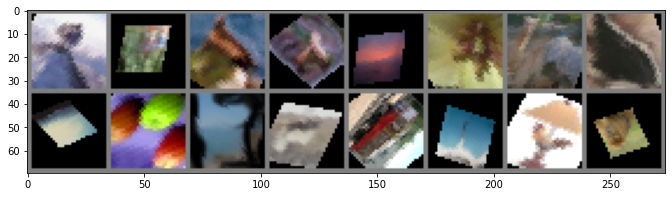

GroundTruth:    mountain,   flatfish,       seal,  mushrooms,        sea,     tulips,      camel,  butterfly,      cloud,     apples,        sea,      skunk,  streetcar,     rocket,       lamp,       lion
Predicted:     telephone,   flatfish,    tractor, chimpanzee,     apples,       lion,    leopard, chimpanzee,      cloud,    orchids,        sea,       road, motorcycle,        sea,  cockroach,       lion


In [41]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
outputs = inzvaNet(images)
_, predicted = torch.max(outputs.data, 1)
# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ', '.join('%10s' % classes[labels[j]] for j in range(hparams['batch_size'])))
print('Predicted:   ', ', '.join('%10s' % classes[predicted[j]]for j in range(hparams['batch_size'])))

In [35]:
# test on all test data
inzvaNet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = inzvaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("correct predictions: ", correct)
print("total number of data: ", total)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

correct predictions:  1318
total number of data:  10000
Accuracy of the network on the 10000 test images: 13 %


In [39]:
# class-wise accuracy
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = inzvaNet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(hparams['batch_size']):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("Accuracy of classes:")
for i in range(100):
    print('%3d- %20s : %5.3f %%' % (
        i+1, classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of classes:
  1-               apples : 51.000 %
  2-        aquarium fish : 11.000 %
  3-                 baby : 12.000 %
  4-                 bear : 11.000 %
  5-               beaver : 15.000 %
  6-                  bed : 7.000 %
  7-                  bee : 1.000 %
  8-               beetle : 14.000 %
  9-              bicycle : 9.000 %
 10-              bottles : 4.000 %
 11-                bowls : 0.000 %
 12-                  boy : 0.000 %
 13-               bridge : 8.000 %
 14-                  bus : 3.000 %
 15-            butterfly : 7.000 %
 16-                camel : 8.000 %
 17-                 cans : 7.000 %
 18-               castle : 20.000 %
 19-          caterpillar : 16.000 %
 20-               cattle : 2.000 %
 21-                chair : 21.000 %
 22-           chimpanzee : 45.000 %
 23-                clock : 0.000 %
 24-                cloud : 42.000 %
 25-            cockroach : 52.000 %
 26-    computer keyboard : 0.000 %
 27-                couch : 0.0

### Hyper-Parameter Optimization